# Laying foundations to quantify the "Effort of Reproducibility"

### Abstract
> Why are some research studies easy to reproduce while others are
difficult? Casting doubt on the accuracy of scientific work is not
fruitful, especially when an individual researcher cannot reproduce
the claims made in the paper. There could be many subjective reasons behind the inability to reproduce a scientific paper. The field of
Machine Learning (ML) faces a reproducibility crisis, and surveying
a portion of published articles has resulted in a group realization
that although sharing code repositories would be appreciable, code
bases are not the end all be all for determining the reproducibility of
an article. Various parties involved in the publication process have
come forward to address the reproducibility crisis and solutions
such as badging articles as reproducible, reproducibility checklists
at conferences (NeurIPS, ICML, ICLR, etc.), and sharing artifacts
on OpenReview come across as promising solutions to the core
problem. The breadth of literature on reproducibility focuses on
measures required to avoid ir-reproducibility, and there is not much
research into the effort behind reproducing these articles. In this
paper, we investigate the factors that contribute to the easiness and
difficulty of reproducing previously published studies and report
on the foundational framework to quantify effort of reproducibility

### Author(s)
[Akhil Pandey Akella](https://akhilpandey95.com/about), [David Koop](https://faculty.cs.niu.edu/~dakoop/), [Hamed Alhoori](https://alhoori.github.io)

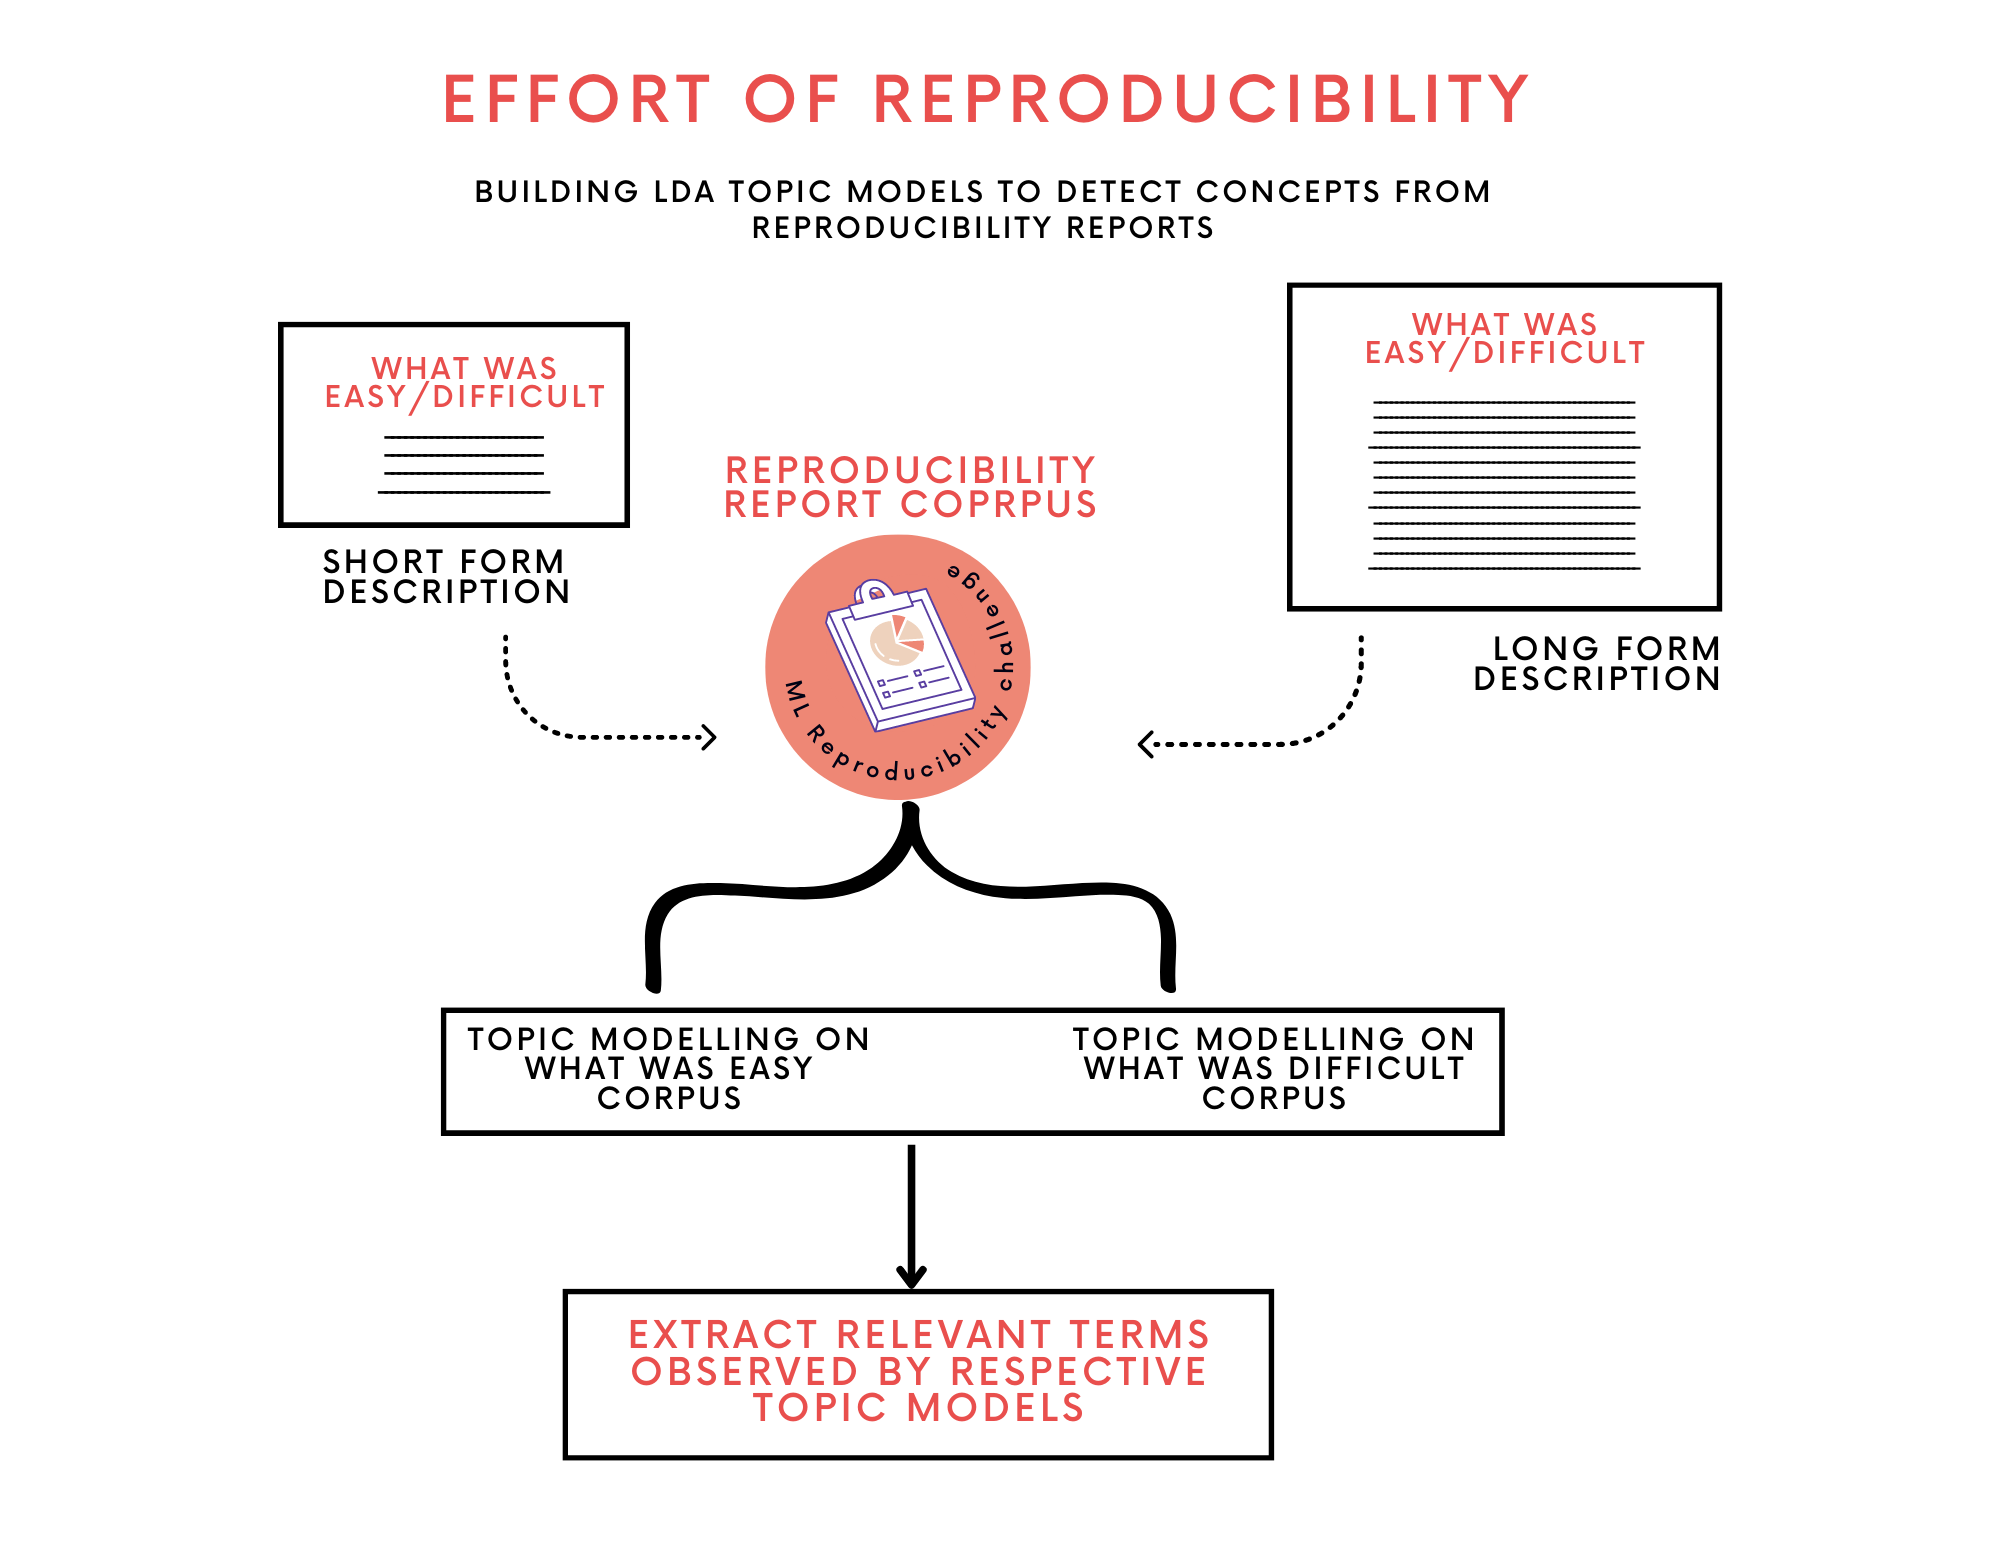

## About
The idea of estimating the underlying effort in reproducing scholarly articles is slightly new, and the [NIH article](https://www.ncbi.nlm.nih.gov/books/NBK350355/) serves as a good starting point to get some historical perspective on the topic. In an attempt to estimate "Effort in Reproducibility", we collected replication reports from **Machine Learning Reproducibility Challenge** ([2020](http://rescience.github.io/read/#volume-7-2021), [2021](http://rescience.github.io/read/#volume-8-2022)). The primary goal of **ML Reproducibility Challenge** was to have a community of researchers investigate the claims made in scholarly articles published at top conferences. The community selected papers and attempted to verify the claims made in the paper by reproducing computational experiments. The reports published on [ReScience](http://rescience.github.io/read/) were a by-product outlining the underlying effort behind reproducing the papers. We believe these reports to be a good starting point for understanding the operational framework of reproducibility. The reports had detailed information about the scope of reproducibility and what was easy and difficult for the researchers while replicating the original article.

**More information about the project is available on our [Github repo](https://raw.githubusercontent.com/reproducibilityproject/effortly).**

In [1]:
#@title Install necessary packages

# install pyldavis
!pip install -q pyLDAvis

In [2]:
#@title Import necessary packages for building Gensim based LDA model
# This Source Code Form is subject to the terms of the MIT
# License. If a copy of the same was not distributed with this
# file, You can obtain one at
# https://github.com/reproducibilityproject/effortly/blob/main/LICENSE

import warnings
import operator
import math
import spacy
import random
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from ast import literal_eval
from sklearn.manifold import TSNE
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from gensim.models import TfidfModel
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from  matplotlib.ticker import FuncFormatter
from gensim.corpora.dictionary import Dictionary
from collections import Counter, defaultdict

# ignore warnings
warnings.filterwarnings("ignore")

# matplotlib
%matplotlib inline

In [3]:
#@title Load the data
# read the dataframe
raw_data = pd.read_csv('ReScience_JCDL-23.csv')

# show columns
raw_data.columns

Index(['author', 'title', 'doi', 'article_type', 'lang', 'pdf_url', 'keywords',
       'review_url', 'code_url', 'volume', 'issue', 'year', 'abstract', 'easy',
       'difficult', 'gs_citations', 'gs_scholar_url', 'original_pdf_url',
       'original_article_url', 'reason_for_easiness', 'reason_for_difficulty',
       'limitations_results', 'scope_of_reproducibility', 'original_abstract',
       'orig_art_sciparse_full_text', 'orig_art_pdfminer_full_text',
       'original_sections', 'no_hyp', 'no_alg', 'no_images', 'no_equations',
       'no_tables', 'is_meth_pres', 'is_intro_pres', 'link_to_code_available',
       'mean_readability', 'hyp_available_in_text', 'easiness_longform',
       'difficult_longform', 'list_for_limitations', 'list_for_diff',
       'list_for_easiness', 'more_than_one_easy'],
      dtype='object')

In [4]:
#@title Install spacy + scibert related packages
# install scispacy
!pip install -q scispacy

# install specific scispacy model
!pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz

# install spacy transformers
!pip install -q spacy[transformers]

  Preparing metadata (setup.py) ... done


In [5]:
#@title Prepare the corpus for downstream topic modelling tasks
# create an empty dict
dict_ = {'paper_id': [], 'easy': [], 'difficult': [], 'easy_text': [], 'difficult_text': []}

# set the counter to zero
i = 0

#instantiating English module
nlp = spacy.load('en_core_sci_scibert')

#Creating the pipeline 'sentencizer' component
nlp.add_pipe("sentencizer")

for index in tqdm(range(len(raw_data))):
    if type(raw_data.easiness_longform[index]) != str and math.isnan(raw_data.easiness_longform[index]):
        # clean the text from the column easy
        content_easy = nlp(raw_data.easy[index])
    elif type(raw_data.easiness_longform[index]) == str:
        # add the long form text from the column easy
        content_easy = nlp(raw_data.easiness_longform[index])

    if type(raw_data.difficult_longform[index]) != str and math.isnan(raw_data.difficult_longform[index]):
        # clean the text from the column difficult
        content_difficult = nlp(raw_data.difficult[index])
    elif type(raw_data.easiness_longform[index]) == str:
        # add the long form text from the column difficult
        content_difficult = nlp(raw_data.difficult_longform[index])

    # tokenize all of the words from the column easy
    tokens_easy = [token.text for token in content_easy if token.is_stop == False \
                   and token.text.isalpha() == True]

    # tokenize all of the words from the column difficult
    tokens_difficult = [token.text for token in content_difficult if token.is_stop == False \
                        and token.text.isalpha() == True]

    # add the paper id to the dict
    dict_['paper_id'].append(raw_data.doi[index])

    # add the tokenized words from the section "what was easy" to the dict
    dict_['easy'].append(tokens_easy)

    # add the text from the section "what was easy" to the dict
    dict_['easy_text'].append(content_easy)

    # add the tokenized words from the section "what was difficult" to the dict
    dict_['difficult'].append(tokens_difficult)

    # add the text from the section "what was difficult" to the dict
    dict_['difficult_text'].append(content_difficult)

# add the data to the dataframe
topic_df = pd.DataFrame.from_dict(dict_)

# show the first five rows
topic_df.head()

100%|██████████| 70/70 [07:56<00:00,  6.81s/it]


,paper_id,easy,difficult,easy_text,difficult_text
0,10.5281/zenodo.6574625,"[easy, set, environment, README, file, Github,...","[case, architecture, ImageNet, replacing, Imag...","(It, was, easy, to, set, up, the, environment,...","(In, the, case, of, the, architecture, for, Im..."
1,10.5281/zenodo.6574629,"[paper, written, easy, follow, provided, clear...","[codebase, incomplete, took, lot, time, solve,...","(The, paper, was, well, written, and, easy, to...","(Since, the, codebase, was, incomplete, ,, it,..."
2,10.5281/zenodo.6574631,"[found, particularly, easy, run, understand, c...","[main, difficulty, replicating, study, present...","(\n, We, found, particularly, easy, to, run, a...","(\n, The, main, difficulty, of, replicating, t..."
3,10.5281/zenodo.6574635,"[original, paper, provides, extensive, appendi...","[Nonetheless, reproducing, original, results, ...","(The, original, paper, provides, an, extensive...","(Nonetheless, ,, reproducing, the, original, r..."
4,10.5281/zenodo.6574637,"[code, simulation, logic, need, modifications,...","[codebase, originally, executable, required, m...","(Part, of, the, code, ,, namely, the, simulati...","(The, codebase, was, not, originally, executab..."


In [6]:
#@title Process the corpus
# get id2word for the section "what was easy"
easy_dictionary = Dictionary(topic_df['easy'])

# get id2word for the section "what was difficult"
difficult_dictionary = Dictionary(topic_df['difficult'])

# filter extremes
easy_dictionary.filter_extremes(no_above=0.5)
difficult_dictionary.filter_extremes(no_above=0.5)

# build the corpus for the section "what was easy"
corpus_easy = [easy_dictionary.doc2bow(doc) for doc in topic_df['easy']]

# build the corpus for the section "what was difficult"
corpus_difficult = [difficult_dictionary.doc2bow(doc) for doc in topic_df['difficult']]

In [7]:
#@title TF-IDF on "What was easy"

# build the vocab for the "What was easy" texts
easy_vocab = [easy_dictionary[i] for i in range(len(easy_dictionary))]

# index the vocabulary
easy_vocab_index = list(range(len(corpus_easy)))

# build the gensim Tfidf model on the easy corpus
easy_tfidf = TfidfModel(corpus_easy)

# build the empty dataframe with zeros awaiting to be filled with frequency
easy_tfidf_df = pd.DataFrame(data= np.zeros((len(corpus_easy), \
                                            len(easy_vocab)), \
                                            dtype=np.float16), \
                                            index=easy_vocab_index, \
                                            columns=easy_vocab)

# attach the term frequency weights on the vocabulary
for idx in easy_vocab_index:
    for id, freq in easy_tfidf[corpus_easy[idx]]:
        easy_tfidf_df[easy_dictionary[id]][idx] = freq

easy_tfidf_df.columns

Index(['architecture', 'clearly', 'codebase', 'data', 'dataset', 'easier',
       'experiments', 'files', 'helped', 'hyperparameters', 'network',
       'repository', 'run', 'scripts', 'set', 'structured', 'understand',
       'clear', 'follow', 'implementation', 'provided', 'relatively',
       'written', 'found', 'missing', 'original', 'reproduce', 'required',
       'datasets', 'details', 'extensive', 'included', 'instructions',
       'publicly', 'straightforward', 'training', 'available', 'implemented',
       'making', 'model', 'models', 'documented', 'presented', 'provide',
       'Additionally', 'algorithm', 'allowed', 'different', 'easily', 'ideas',
       'lot', 'method', 'proposed', 'running', 'work', 'methods', 'et',
       'implementing', 'needed', 'reproduction', 'algorithms', 'described',
       'implement', 'problem', 'Attribution', 'C', 'Code', 'Commons',
       'Copyright', 'Correspondence', 'Creative', 'International', 'Open',
       'ReScience', 'SWH', 'addressed', 

In [8]:
#@title TF-IDF on "What was difficult"

# build the vocab for the "What was difficult" texts
difficult_vocab = [difficult_dictionary[i] for i in range(len(difficult_dictionary))]

# index the vocabulary
difficult_vocab_index = list(range(len(corpus_difficult)))

# build the gensim Tfidf model on the difficult corpus
difficult_tfidf = TfidfModel(corpus_difficult)

# build the empty dataframe with zeros awaiting to be filled with frequency
difficult_tfidf_df = pd.DataFrame(data= np.zeros((len(corpus_difficult), \
                                            len(difficult_vocab)), \
                                            dtype=np.float16), \
                                            index=difficult_vocab_index, \
                                            columns=difficult_vocab)

# attach the term frequency weights on the vocabulary
for idx in difficult_vocab_index:
    for id, freq in difficult_tfidf[corpus_difficult[idx]]:
        difficult_tfidf_df[difficult_dictionary[id]][idx] = freq

difficult_tfidf_df.columns

Index(['Code', 'GPU', 'ImageNet', 'able', 'architecture', 'baseline', 'block',
       'case', 'challenge', 'changes',
       ...
       'machine', 'seeds', 'helped', 'impact', 'improve', 'finding',
       'independent', 'source', 'authorsʼ', 'implementations'],
      dtype='object', length=651)

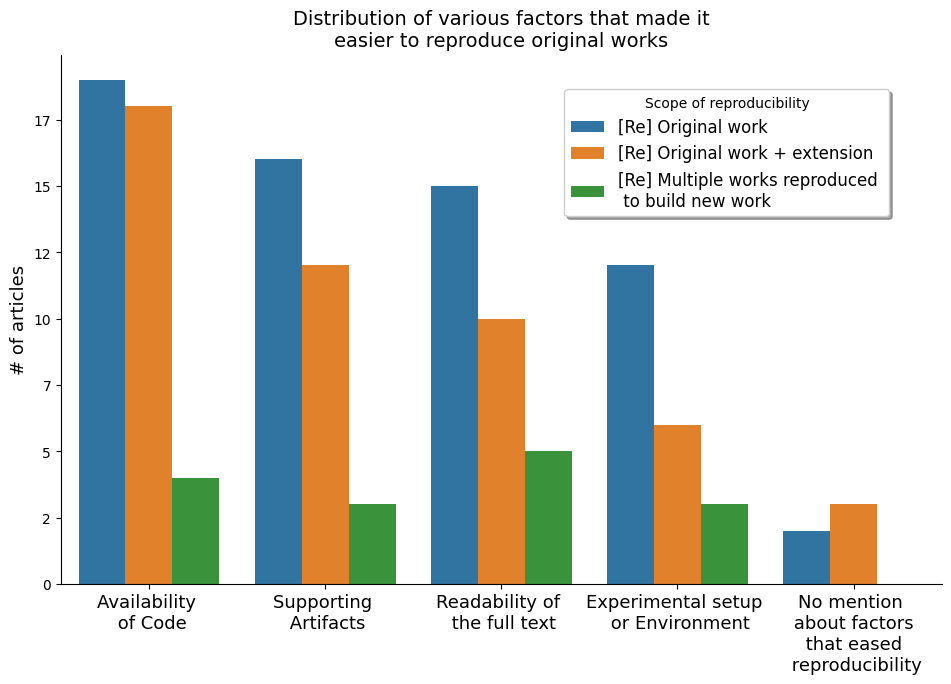

In [10]:
#@title Distribution of various factors that made it easier to reproduce original works

import itertools

# a dictionary map highlighting various reasons for easiness
easy_map = {
    1: 'Availability \n of Code',
    2: 'Supporting \n Artifacts',
    3: 'Readability of \n the full text',
    4: 'Experimental setup \n or Environment',
    5: 'No mention \n about factors \n that eased \n reproducibility'
}

# map the reasons for easiness into a list
more_than_one_easy = [list(map(lambda x: {'doi': doi, \
                                          'reason': easy_map[literal_eval(x.strip())], \
                                          'scope': scope}, reason.split(',')) ) \
                      for doi, reason, scope in zip(raw_data.doi, \
                                               raw_data.reason_for_easiness, \
                                               raw_data.scope_of_reproducibility)]

# flatten the list
more_than_one_easy = list(itertools.chain(*more_than_one_easy))

# convert the list of dicts to a dataframe
more_than_one_easy = pd.DataFrame.from_dict(more_than_one_easy)

# build the historgram
g = sns.catplot(
    data=more_than_one_easy, x="reason", \
    hue="scope",
    kind="count",
    order=more_than_one_easy['reason'].value_counts().index,
    legend=False
)

# adjust height and width of the article
g.fig.set_figwidth(11.0)
g.fig.set_figheight(7.0)

# adjust labels and ticks
plt.xlabel('')
plt.ylabel('# of articles', fontsize=13)
plt.xticks(fontsize=13)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

# create title and legend
plt.title("""Distribution of various factors that made it
easier to reproduce original works""", fontsize=14)

plt.legend(title='Scope of reproducibility', \
           bbox_to_anchor=(0.95, 0.95),
           loc='upper right', \
           frameon=True, \
           shadow=True,
           fontsize=12,
           labels=['[Re] Original work',\
                   '[Re] Original work + extension',\
                   '[Re] Multiple works reproduced \n to build new work'])

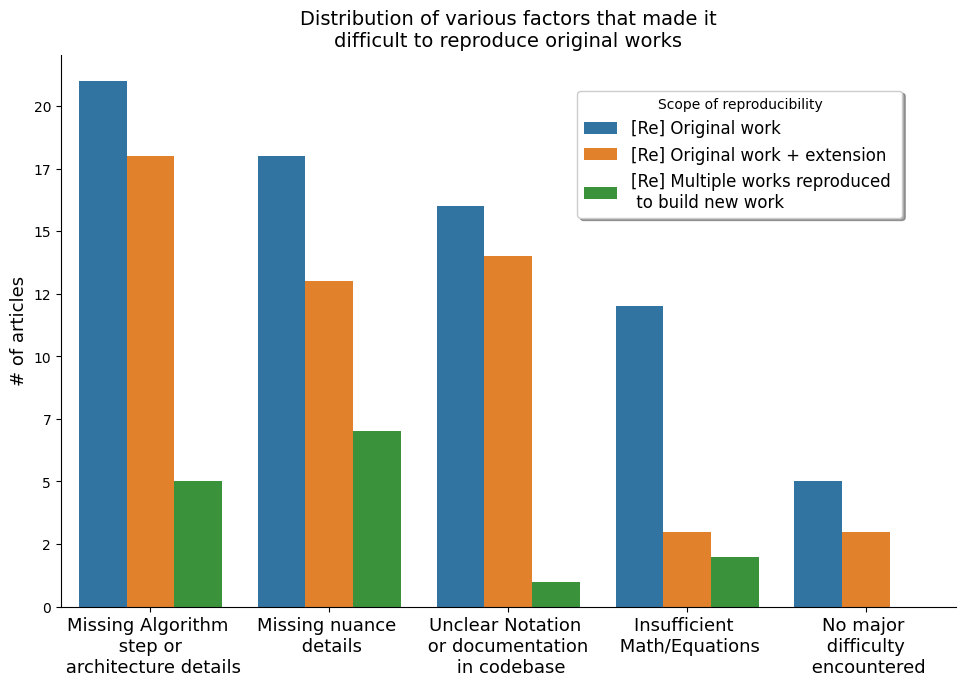

In [11]:
#@title Distribution of various factors that made it difficult to reproduce original works
# a dictionary map highlighting various reasons for difficulty
diff_map = {
    1: 'Unclear Notation \n or documentation \n in codebase',
    2: 'Missing Algorithm \n step or \n architecture details',
    3: 'Insufficient \n Math/Equations',
    4: 'Missing nuance \n details',
    5: 'No major \n difficulty \n encountered',
}

# map the reasons for easiness into a list
list_for_diff = [diff_map[literal_eval(x)] if len(x) == 1 else 'More than one reason' \
                     for x in raw_data.reason_for_difficulty]


# map the reasons for difficulty into a list
more_than_one_diff = [list(map(lambda x: {'doi': doi, \
                                          'reason': diff_map[literal_eval(x.strip())], \
                                          'scope': scope}, reason.split(',')) ) \
                      for doi, reason, scope in zip(raw_data.doi, \
                                               raw_data.reason_for_difficulty, \
                                               raw_data.scope_of_reproducibility)]

# flatten the list
more_than_one_diff = list(itertools.chain(*more_than_one_diff))

# convert the list of dicts to a dataframe
more_than_one_diff = pd.DataFrame.from_dict(more_than_one_diff)

# build the historgram
g = sns.catplot(
    data=more_than_one_diff, x="reason", \
    hue="scope",
    kind="count",
    order=more_than_one_diff['reason'].value_counts().index,
    legend=False
)

# adjust height and width of the article
g.fig.set_figwidth(11.0)
g.fig.set_figheight(7.0)

# adjust labels and ticks
plt.xlabel('')
plt.ylabel('# of articles', fontsize=13)
plt.xticks(fontsize=13)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

# create title and legend
plt.title("""Distribution of various factors that made it
difficult to reproduce original works""", fontsize=14)

plt.legend(title='Scope of reproducibility', \
           bbox_to_anchor=(0.95, 0.95),
           loc='upper right', \
           frameon=True, \
           shadow=True,
           fontsize=12,
           labels=['[Re] Original work',\
                   '[Re] Original work + extension',\
                   '[Re] Multiple works reproduced \n to build new work'])

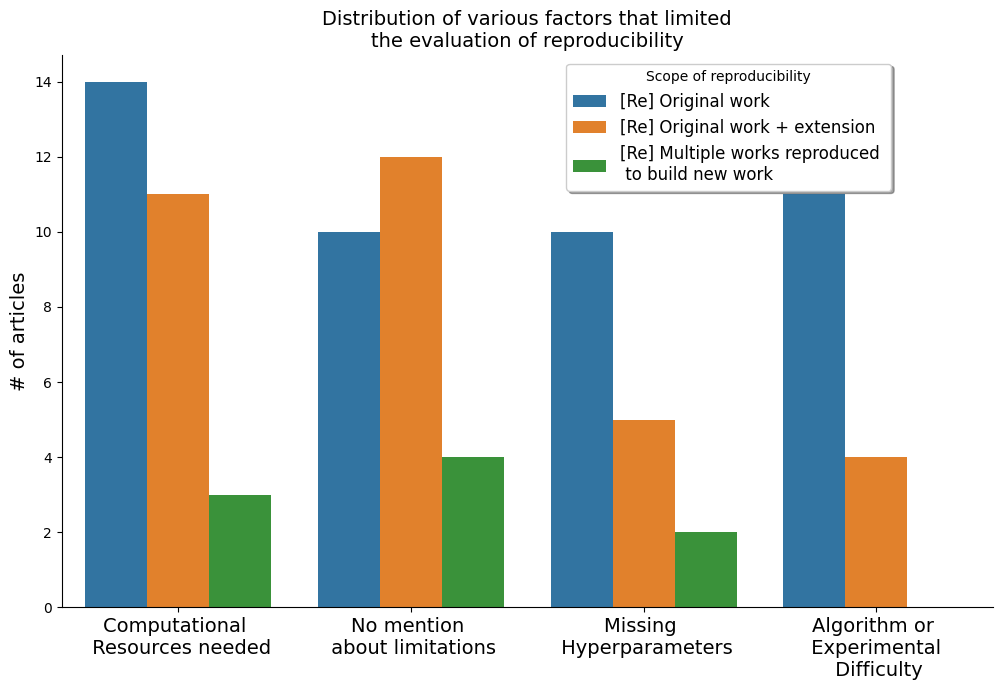

In [12]:
#@title Distribution of various factors that limited the evaluation of reproducibility
# a dictionary map highlighting various reasons for limitations
limitations_map = {
    1: 'Algorithm or \n Experimental \n Difficulty',
    2: 'Computational \n Resources needed',
    3: 'Missing \n Hyperparameters',
    4: 'No mention \n about limitations'
}

# map the reasons for easiness into a list
list_for_limitations = [limitations_map[literal_eval(x)] if len(x) == 1 else 'More than \n one limitation' \
                     for x in raw_data.limitations_results]

# map the mentioned limitations into a list
more_than_one_limitation = [list(map(lambda x: {'doi': doi, \
                                          'limitation': limitations_map[literal_eval(x.strip())], \
                                          'scope': scope}, limitation.split(',')) ) \
                      for doi, limitation, scope in zip(raw_data.doi, \
                                               raw_data.limitations_results, \
                                               raw_data.scope_of_reproducibility)]

# flatten the list
more_than_one_limitation = list(itertools.chain(*more_than_one_limitation))

# convert the list of dicts to a dataframe
more_than_one_limitation = pd.DataFrame.from_dict(more_than_one_limitation)

# build the historgram
g = sns.catplot(
    data=more_than_one_limitation, x="limitation", \
    hue="scope",
    kind="count",
    order=more_than_one_limitation['limitation'].value_counts().index,
    legend=False
)

# adjust height and width of the article
g.fig.set_figwidth(11.0)
g.fig.set_figheight(7.0)

# adjust labels and ticks
plt.xlabel('')
plt.ylabel('# of articles', fontsize=14)
plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

# create title and legend
plt.title("""Distribution of various factors that limited
the evaluation of reproducibility""", fontsize=14)

plt.legend(title='Scope of reproducibility', \
           bbox_to_anchor=(0.90, 1.00),
           loc='upper right', \
           frameon=True, \
           shadow=True,
           fontsize=12,
           labels=['[Re] Original work',\
                   '[Re] Original work + extension',\
                   '[Re] Multiple works reproduced \n to build new work'])

In [13]:
#@title Build the LDA multicore model
# start the multicore LDA model
ldah_easy = LdaMulticore(
                        corpus=corpus_easy,
                        num_topics=5,
                        id2word=easy_dictionary,
                        workers=8,
                        passes=30,
                        random_state=6745,
                        per_word_topics=True)

# start the multicore LDA model
ldah_difficult = LdaMulticore(
                        corpus=corpus_difficult,
                        num_topics=5,
                        id2word=difficult_dictionary,
                        workers=8,
                        passes=30,
                        random_state=6745,
                        per_word_topics=True)

In [14]:
#@title Display Perplexity and Coherence metrics for both the LDA models
# Compute Perplexity Easy
print('Perplexity for LDA model trained on "What was easy" corpus: ', ldah_easy.log_perplexity(corpus_easy))

# Compute Coherence Score Easy
coherence_model_lda_easy = CoherenceModel(model=ldah_easy, texts=topic_df['easy'].values.tolist(), dictionary=easy_dictionary, coherence='c_v')
coherence_lda_easy = coherence_model_lda_easy.get_coherence()
print('Coherence Score for LDA model trained on "What was easy" corpus: ', coherence_lda_easy)

# Compute Perplexity Difficult
print('\nPerplexity for LDA model trained on "What was difficult" corpus: ', ldah_difficult.log_perplexity(corpus_difficult))

# Compute Coherence Score Difficult"
coherence_model_lda_diff = CoherenceModel(model=ldah_difficult, texts=topic_df['difficult'].values.tolist(), dictionary=difficult_dictionary, coherence='c_v')
coherence_lda_diff = coherence_model_lda_diff.get_coherence()
print('Coherence Score for LDA model trained on "What was difficult" corpus: ', coherence_lda_diff)

Perplexity for LDA model trained on "What was easy" corpus:  -4.551205612953354
Coherence Score for LDA model trained on "What was easy" corpus:  0.42699350331582836

Perplexity for LDA model trained on "What was difficult" corpus:  -6.163060071483156
Coherence Score for LDA model trained on "What was difficult" corpus:  0.3341472672847421


In [15]:
#@title Build visualization objects for the LDA models
lda_visualization_easy = pyLDAvis.gensim_models.prepare(ldah_easy, \
                                            corpus_easy, \
                                            easy_dictionary, \
                                            sort_topics=False)

lda_visualization_difficult = pyLDAvis.gensim_models.prepare(ldah_difficult, \
                                            corpus_difficult, \
                                            difficult_dictionary, \
                                            sort_topics=False)

In [16]:
pyLDAvis.display(lda_visualization_easy)

In [17]:
pyLDAvis.display(lda_visualization_difficult)

In [18]:
#@title Utility function for plotting optimum number of topics vs coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    random_state : List of random states used to create the LDA model
    """
    random_states = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        rs = math.floor(random.random()*10000)
        random_states.append(rs)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           passes=30,
                                           random_state=rs)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, random_states

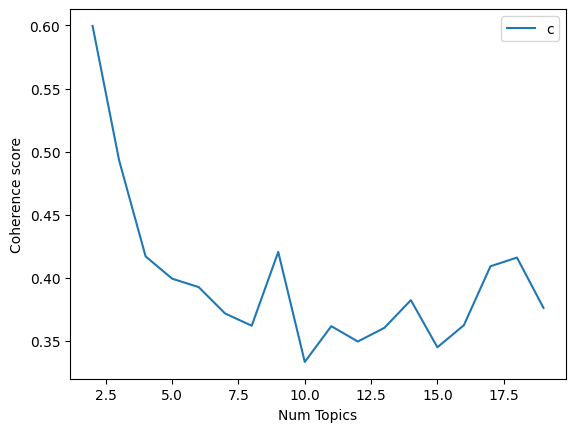

Num Topics = 2  has Coherence Value of 0.5996  with Random state 842
Num Topics = 3  has Coherence Value of 0.4931  with Random state 5299
Num Topics = 4  has Coherence Value of 0.417  with Random state 1060
Num Topics = 5  has Coherence Value of 0.3993  with Random state 7541
Num Topics = 6  has Coherence Value of 0.3926  with Random state 448
Num Topics = 7  has Coherence Value of 0.3717  with Random state 494
Num Topics = 8  has Coherence Value of 0.362  with Random state 8129
Num Topics = 9  has Coherence Value of 0.4205  with Random state 3248
Num Topics = 10  has Coherence Value of 0.3334  with Random state 3919
Num Topics = 11  has Coherence Value of 0.3617  with Random state 8117
Num Topics = 12  has Coherence Value of 0.3495  with Random state 1476
Num Topics = 13  has Coherence Value of 0.3603  with Random state 9828
Num Topics = 14  has Coherence Value of 0.3823  with Random state 6395
Num Topics = 15  has Coherence Value of 0.345  with Random state 7353
Num Topics = 16  has

In [19]:
#@title Plot optimum number of topics against coherence scores for "What was easy" corpus
model_list, coherence_values, random_states = compute_coherence_values(dictionary=easy_dictionary, \
                                                        corpus=corpus_easy, \
                                                        texts=topic_df['easy'].values.tolist(), \
                                                        start=2, \
                                                        limit=20, \
                                                        step=1)

limit=20
start=2
step=1

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv, rs in zip(x, coherence_values, random_states):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " with Random state", rs)

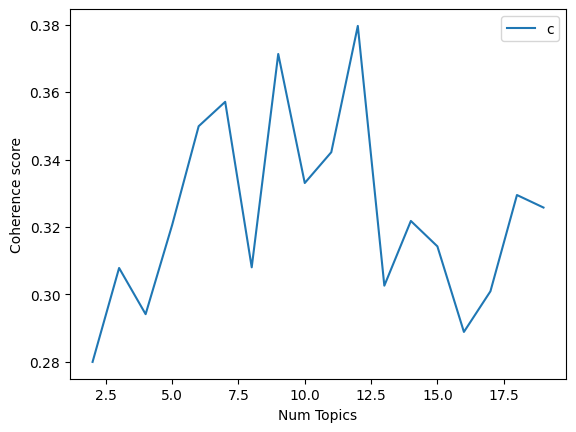

Num Topics = 2  has Coherence Value of 0.28  with Random state 5689
Num Topics = 3  has Coherence Value of 0.3078  with Random state 7857
Num Topics = 4  has Coherence Value of 0.2941  with Random state 8006
Num Topics = 5  has Coherence Value of 0.3206  with Random state 3166
Num Topics = 6  has Coherence Value of 0.3499  with Random state 731
Num Topics = 7  has Coherence Value of 0.3571  with Random state 2208
Num Topics = 8  has Coherence Value of 0.308  with Random state 8031
Num Topics = 9  has Coherence Value of 0.3713  with Random state 4244
Num Topics = 10  has Coherence Value of 0.333  with Random state 6367
Num Topics = 11  has Coherence Value of 0.3422  with Random state 9030
Num Topics = 12  has Coherence Value of 0.3796  with Random state 626
Num Topics = 13  has Coherence Value of 0.3026  with Random state 2286
Num Topics = 14  has Coherence Value of 0.3218  with Random state 5553
Num Topics = 15  has Coherence Value of 0.3143  with Random state 1538
Num Topics = 16  has

In [20]:
#@title Plot optimum number of topics against coherence scores for "What was difficult" corpus
model_list, coherence_values, random_states = compute_coherence_values(dictionary=difficult_dictionary, \
                                                        corpus=corpus_difficult, \
                                                        texts=topic_df['difficult'].values.tolist(), \
                                                        start=2, \
                                                        limit=20, \
                                                        step=1)

limit=20
start=2
step=1

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv, rs in zip(x, coherence_values, random_states):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " with Random state", rs)

# Part 2. Analysing and evaluating the Topic Models

In [21]:
ldah_easy.print_topics(num_words=10)

[(0,
  '0.130*"training" + 0.076*"straightforward" + 0.073*"et" + 0.073*"original" + 0.053*"data" + 0.052*"model" + 0.049*"available" + 0.044*"implementation" + 0.043*"implementing" + 0.040*"publicly"'),
 (1,
  '0.071*"provided" + 0.061*"experiments" + 0.061*"implementation" + 0.038*"models" + 0.038*"original" + 0.033*"codebase" + 0.028*"model" + 0.027*"run" + 0.026*"easily" + 0.025*"required"'),
 (2,
  '0.082*"experiments" + 0.075*"datasets" + 0.064*"training" + 0.050*"details" + 0.046*"reproduce" + 0.036*"provide" + 0.036*"clear" + 0.036*"extensive" + 0.036*"network" + 0.032*"model"'),
 (3,
  '0.047*"clear" + 0.046*"understand" + 0.045*"results" + 0.038*"experiments" + 0.037*"codebase" + 0.034*"helped" + 0.033*"original" + 0.033*"provided" + 0.029*"model" + 0.028*"straightforward"'),
 (4,
  '0.067*"available" + 0.033*"released" + 0.033*"license" + 0.033*"competing" + 0.033*"Correspondence" + 0.033*"Attribution" + 0.033*"Creative" + 0.033*"addressed" + 0.033*"Copyright" + 0.033*"exist

In [22]:
ldah_difficult.print_topics(num_words=10)

[(0,
  '0.023*"dataset" + 0.018*"data" + 0.017*"implementation" + 0.014*"algorithm" + 0.012*"provided" + 0.010*"use" + 0.009*"et" + 0.009*"number" + 0.008*"method" + 0.008*"able"'),
 (1,
  '0.028*"training" + 0.028*"loss" + 0.023*"label" + 0.021*"noise" + 0.019*"losses" + 0.018*"data" + 0.015*"experiment" + 0.015*"Figure" + 0.014*"accuracy" + 0.012*"learning"'),
 (2,
  '0.021*"training" + 0.014*"datasets" + 0.014*"network" + 0.014*"models" + 0.013*"learning" + 0.013*"time" + 0.011*"dataset" + 0.011*"claim" + 0.011*"images" + 0.010*"use"'),
 (3,
  '0.017*"dataset" + 0.017*"provided" + 0.015*"difficult" + 0.015*"reproduce" + 0.014*"evaluation" + 0.014*"time" + 0.013*"challenges" + 0.013*"work" + 0.011*"claim" + 0.010*"performance"'),
 (4,
  '0.019*"b" + 0.017*"method" + 0.016*"features" + 0.015*"set" + 0.015*"methods" + 0.014*"function" + 0.013*"value" + 0.012*"different" + 0.012*"images" + 0.012*"performance"')]

In [27]:
#@title Build utility functions to format topic keywords and display dominant topics
def format_topics_sent(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([pd.Series([int(topic_num), round(prop_topic,4), topic_keywords])]) ], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Text"}, inplace=True)
    return sent_topics_df

def format_topics_sent_gen(ldamodel, corpus, texts):
    for i, row in enumerate(ldamodel[corpus]):
        yield row

easy_sent_topics_df = format_topics_sent(ldah_easy, corpus_easy, topic_df['easy'].values.tolist())
diff_sent_topics_df = format_topics_sent(ldah_difficult, corpus_difficult, topic_df['difficult'].values.tolist())

In [28]:
# easy_sent_topics_df.head(5)
# easy_sent_topics_df.drop_duplicates(subset = ["Dominant_topic"])
easy_sent_topics_df[easy_sent_topics_df.Perc_Contrib >= 0.9].drop_duplicates(subset = ["Dominant_topic"])[['Dominant_topic', 'Topic_Keywords']]

,Dominant_topic,Topic_Keywords
0,3,"clear, understand, results, experiments, codeb..."
2,1,"provided, experiments, implementation, models,..."
11,0,"training, straightforward, et, original, data,..."
15,4,"available, released, license, competing, Corre..."
28,2,"experiments, datasets, training, details, repr..."


In [29]:
# diff_sent_topics_df.head(5)
# diff_sent_topics_df.drop_duplicates(subset = ["Dominant_topic"])
diff_sent_topics_df[diff_sent_topics_df.Perc_Contrib >= 0.99].drop_duplicates(subset = ["Dominant_topic"])[['Dominant_topic', 'Topic_Keywords']]

,Dominant_topic,Topic_Keywords
1,2,"training, datasets, network, models, learning,..."
29,4,"b, method, features, set, methods, function, v..."
30,0,"dataset, data, implementation, algorithm, prov..."
39,3,"dataset, provided, difficult, reproduce, evalu..."
59,1,"training, loss, label, noise, losses, data, ex..."


In [30]:
#@title LDA Model average cosine similarity
import itertools

def process_topic_dist(topic_dist):
  dist = topic_dist[2]
  return [[x[0], x[1][0][1]] for x in dist]

def intra_inter(model, dictionary, documents, num_pairs=10000):
    # split each test document into two halves and compute topics for each half
    part1 = [process_topic_dist(model[dictionary.doc2bow(tokens[: math.ceil(len(tokens) / 2)])]) for tokens in documents]
    part2 = [process_topic_dist(model[dictionary.doc2bow(tokens[math.ceil(len(tokens) / 2): ])]) for tokens in documents]

    # print computed similarities (uses cossim)
    print("average cosine similarity between corresponding parts (higher is better):")
    print(np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)]))

    random_pairs = np.random.randint(0, len(documents), size=(num_pairs, 2))
    print("average cosine similarity between 10,000 random parts (lower is better):")
    print(np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs]))

print("LDA Easy results:")
intra_inter(ldah_easy, easy_dictionary, topic_df['easy'])

print("---------")

print("LDA Difficult results:")
intra_inter(ldah_difficult, difficult_dictionary, topic_df['difficult'])

LDA Easy results:
average cosine similarity between corresponding parts (higher is better):
0.11320302626589647
average cosine similarity between 10,000 random parts (lower is better):
0.07472109962251336
---------
LDA Difficult results:
average cosine similarity between corresponding parts (higher is better):
0.18912153018068747
average cosine similarity between 10,000 random parts (lower is better):
0.06273447681643103


In [45]:
index=6
print("""
The original code did not contain any documentation, which made it difficult to navi‐
gate. No code for calculating the metrics was provided and this had to be implemented
from scratch. During the training of the models, memory allocation issues occurred.
Training and evaluating on a large dataset took a considerable amount of time.
""")
print("Ground Truth:", raw_data.iloc[index].reason_for_difficulty)


The original code did not contain any documentation, which made it difficult to navi‐
gate. No code for calculating the metrics was provided and this had to be implemented
from scratch. During the training of the models, memory allocation issues occurred.
Training and evaluating on a large dataset took a considerable amount of time.

Ground Truth: 1, 2


In [46]:
index=48
print("""
Implementing most of the code was straightforward
as authors of both papers provide source code.
GitHub issues were another source of retrieving information,
clarifying parts of the papers when needed.
Additionally, both of the original papers are quite complete,
well-written making it easy to follow.
""")
print("Ground Truth:", raw_data.iloc[index].reason_for_easiness)


Implementing most of the code was straightforward 
as authors of both papers provide source code. 
GitHub issues were another source of retrieving information, 
clarifying parts of the papers when needed. 
Additionally, both of the original papers are quite complete, 
well-written making it easy to follow.

Ground Truth: 1, 3
